In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

from torch.utils.data import DataLoader
from models import LeNet, StoLeNet
from utils import compute_accuracy, compute_ece_loss

In [2]:
train_deterministic = True # train a deterministic model as starting point 

In [3]:

# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [4]:
device

device(type='cuda')

In [5]:
# prepare data
data_dir = "./data"
fig_dir = "./figs"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=False)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=False)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
# ===================================================== #
# ========= train a deterministic model =============== #
# ===================================================== #
if train_deterministic:
    num_epochs = 10
    base_model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.002, momentum=0.9)

    loss_list, acc_list, ece_list = [[] for _ in range(3)]
    for epoch in range(num_epochs):
        base_model.train()
        batch_loss = []
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = base_model(img)
            loss = criterion(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        avg_loss = sum(batch_loss)/len(batch_loss)
        base_acc = compute_accuracy(base_model, testloader, device=device)
        base_ece = compute_ece_loss(base_model, testloader, device=device)
        print("Base Model Epoch {} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
        loss_list.append(avg_loss)
        acc_list.append(base_acc)
        ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 1.6462 Acc 0.6892 ECE 0.0436
Base Model Epoch 1 Avg Loss 0.7152 Acc 0.7489 ECE 0.0307
Base Model Epoch 2 Avg Loss 0.6151 Acc 0.7769 ECE 0.0221
Base Model Epoch 3 Avg Loss 0.5555 Acc 0.8017 ECE 0.0208
Base Model Epoch 4 Avg Loss 0.5061 Acc 0.8194 ECE 0.0190
Base Model Epoch 5 Avg Loss 0.4723 Acc 0.8185 ECE 0.0123
Base Model Epoch 6 Avg Loss 0.4418 Acc 0.8337 ECE 0.0086
Base Model Epoch 7 Avg Loss 0.4245 Acc 0.8405 ECE 0.0131
Base Model Epoch 8 Avg Loss 0.4033 Acc 0.8479 ECE 0.0109
Base Model Epoch 9 Avg Loss 0.3847 Acc 0.8437 ECE 0.0099


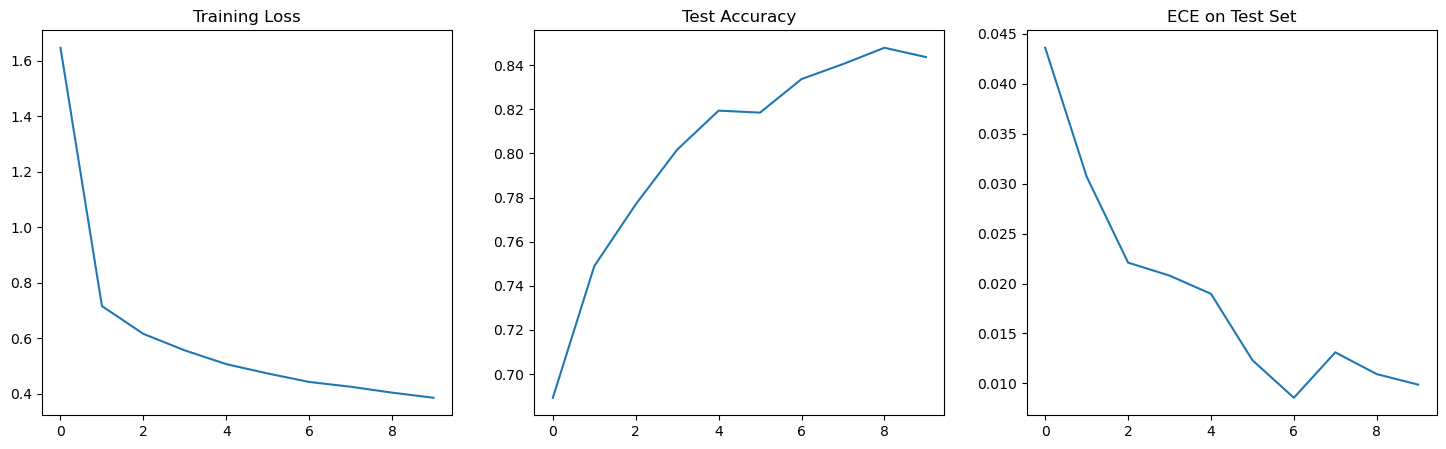

In [7]:
if train_deterministic:
    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    plt.plot(loss_list)
    plt.title("Training Loss")
    plt.subplot(1,3,2)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(1,3,3)
    plt.plot(ece_list)
    plt.title("ECE on Test Set")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "deterministic lenet.jpg")

In [8]:
# ===================================================== #
# =  migrate from base model, finetune and train flow = #
# ===================================================== #

# parameters for base distribution 
NormalParams = lambda scale: {"loc":1.0, "scale":scale}
# flow configurations, List of tuple (type, depth, params)
AffineLayer = [("affine", 1, {"learnable":True})]
GlowStep =  lambda depth, width:[
            ("affine", 1, {"learnable":True}), # the first stack of flows (type, depth, params)
            ("planar2d", 1, {"init_sigma":0.01}),# the second stack of flows (type, depth, params)
            ("flowstep", depth, {"width":width,"keepdim":True}),
            ("planar2d", 1, {"init_sigma":0.01})] 
Planar1d = lambda depth: [("affine", 1), 
            ("planar", depth),
            ("element", 1, {"act":"tanh"})]
# stochastic part for a layer, base distribution name, distribution parameters, flow config 
NormalAffine = ("normal", NormalParams(0.5), AffineLayer)
NormalGlowStep = ("normal", NormalParams(0.5), GlowStep(2, 10))
NormalPlanar1d = ("normal", NormalParams(0.5), Planar1d(2))
# flow config for all layers in the moel 
sto_model_cfg = [NormalAffine, NormalGlowStep, NormalAffine, NormalPlanar1d, NormalAffine]

sto_model = StoLeNet(sto_cfg=sto_model_cfg).to(device)

if train_deterministic:
    sto_model.migrate_from_det_model(base_model)

det_params, sto_params = sto_model.det_and_sto_params()
optimizer = optim.Adam([
                {'params': det_params, 'lr': 2e-4},
                {'params': sto_params, 'lr': 2e-3}
            ])

In [9]:
num_epochs = 30
loss_list, ll_list, kl_list, acc_list, ece_list = [[] for _ in range(5)]
for epoch in range(num_epochs):
    sto_model.train()
    batch_loss, batch_ll, batch_kl = [[] for _ in range(3)]
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        pred = sto_model(img)
        log_likelihood, kl = sto_model.calc_loss(pred, label)
        loss = -log_likelihood + kl / len(trainloader.dataset)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        batch_ll.append(log_likelihood.item()) 
        batch_kl.append(kl.item()/ len(trainloader.dataset))
    avg = lambda l: sum(l)/len(l)
    avg_loss, avg_ll, avg_kl = avg(batch_loss), avg(batch_ll), avg(batch_kl)
    sto_acc = compute_accuracy(sto_model, testloader)
    sto_ece = compute_ece_loss(sto_model, testloader)
    print("Sto Model Epoch {} Avg Loss {:.4f} Likelihood {:.4f} KL {:.4f} Acc {:.4f} ECE {:.4f}".format(
                        epoch, avg_loss, avg_ll, avg_kl,sto_acc, sto_ece))
    loss_list.append(avg_loss)
    ll_list.append(avg_ll)
    kl_list.append(avg_kl)
    acc_list.append(sto_acc)
    ece_list.append(sto_ece)

Sto Model Epoch 0 Avg Loss 0.7230 Likelihood -0.7204 KL 0.0026 Acc 0.8321 ECE 0.0753
Sto Model Epoch 1 Avg Loss 0.5148 Likelihood -0.5111 KL 0.0036 Acc 0.8508 ECE 0.0503
Sto Model Epoch 2 Avg Loss 0.4501 Likelihood -0.4455 KL 0.0046 Acc 0.8571 ECE 0.0289
Sto Model Epoch 3 Avg Loss 0.4088 Likelihood -0.4035 KL 0.0053 Acc 0.8631 ECE 0.0135
Sto Model Epoch 4 Avg Loss 0.3803 Likelihood -0.3743 KL 0.0060 Acc 0.8680 ECE 0.0220
Sto Model Epoch 5 Avg Loss 0.3616 Likelihood -0.3552 KL 0.0064 Acc 0.8747 ECE 0.0195
Sto Model Epoch 6 Avg Loss 0.3442 Likelihood -0.3374 KL 0.0068 Acc 0.8770 ECE 0.0260
Sto Model Epoch 7 Avg Loss 0.3302 Likelihood -0.3230 KL 0.0072 Acc 0.8810 ECE 0.0124
Sto Model Epoch 8 Avg Loss 0.3175 Likelihood -0.3101 KL 0.0075 Acc 0.8850 ECE 0.0050
Sto Model Epoch 9 Avg Loss 0.3040 Likelihood -0.2962 KL 0.0078 Acc 0.8866 ECE 0.0106
Sto Model Epoch 10 Avg Loss 0.2963 Likelihood -0.2882 KL 0.0080 Acc 0.8879 ECE 0.0087
Sto Model Epoch 11 Avg Loss 0.2878 Likelihood -0.2795 KL 0.0082 

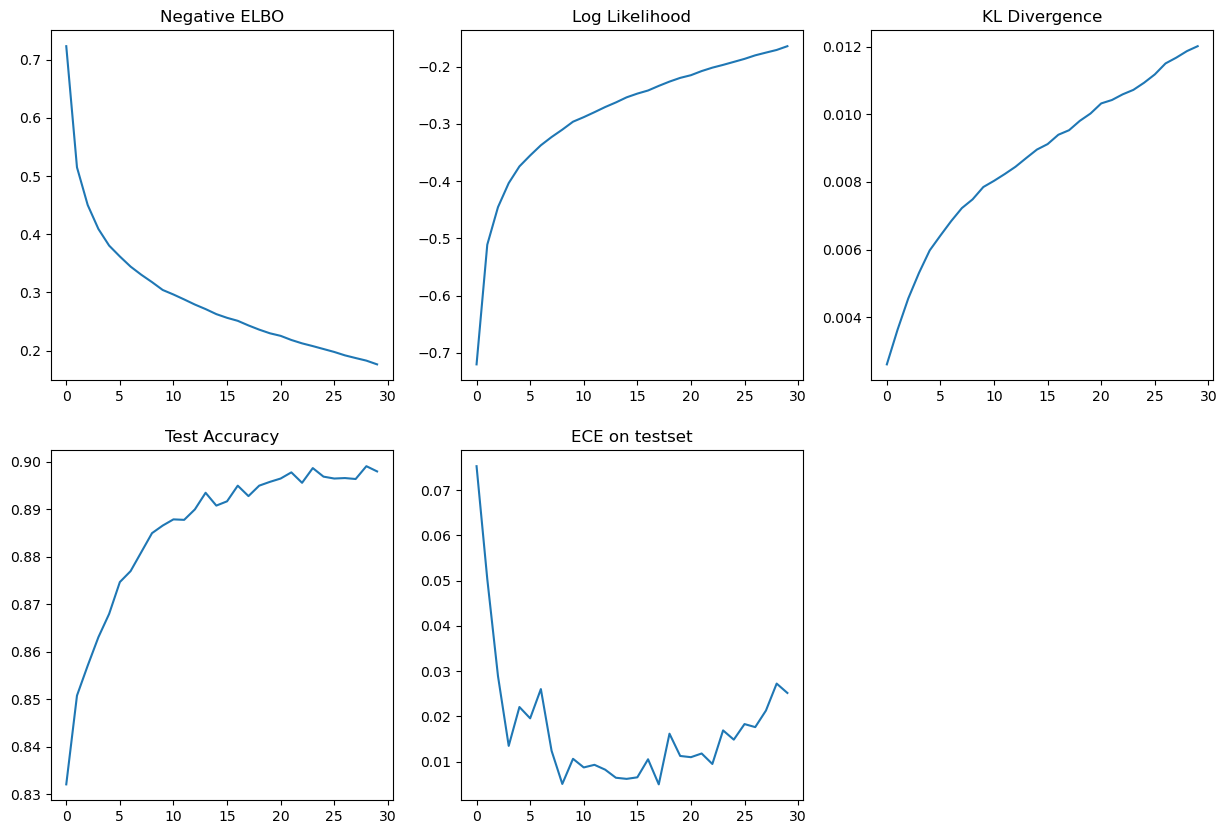

In [10]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(loss_list)
plt.title("Negative ELBO")
plt.subplot(2,3,2)
plt.plot(ll_list)
plt.title("Log Likelihood")
plt.subplot(2,3,3)
plt.plot(kl_list)
plt.title("KL Divergence")
plt.subplot(2,3,4)
plt.plot(acc_list)
plt.title("Test Accuracy")
plt.subplot(2,3,5)
plt.plot(ece_list)
plt.title("ECE on testset")
plt.show()
fig.tight_layout()
fig.savefig(fig_dir + "/" + "stochastic lenet.jpg")

better results compared to last week (without the "step of flow" in Glow paper)

last time the ECE goes higher as training goes on, this time it's lower than the deterministic LeNet

should probably take the check point arount epoch 10, the model seems to overfit after about 15 epochs 

the accuracy increases (84% => 89%): model capacity has been increased by the stochastic part (some has a flow, others don't)

ece is slightly lower (0.01 => 0.006): model is better calibrated, so the flow helps 